<a href="https://colab.research.google.com/github/Bdshetty/loan-approval-prediction/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Preprocessing & ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Save model
import joblib


In [4]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

# Load the uploaded file (replace filename with yours after upload)
filename = list(uploaded.keys())[0]   # automatically picks the uploaded file name
df = pd.read_csv(filename)

# Show first few rows
print(df.head())
print("Dataset Shape:", df.shape)


Saving loan_approval_large_dataset.csv to loan_approval_large_dataset.csv
   Gender Married     Education Self_Employed  ApplicantIncome  \
0    Male      No  Not Graduate           Yes            22003   
1  Female      No  Not Graduate            No             8140   
2  Female      No  Not Graduate            No             5788   
3  Female     Yes  Not Graduate            No            18761   
4  Female     Yes      Graduate           Yes            22369   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0              13581         606               240               1   
1               5939         112               360               0   
2               1783         399               240               1   
3              10067         439               180               1   
4               6630         426               300               0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Urban           N  
2     Semiurban   

In [5]:
# Features & Target
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

# Identify categorical & numerical features
categorical = X.select_dtypes(include=['object']).columns
numerical = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])



In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8000, 10) Test size: (2000, 10)


In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


In [10]:
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label="Y")
    rec = recall_score(y_test, y_pred, pos_label="Y")
    f1 = f1_score(y_test, y_pred, pos_label="Y")
    roc_auc = roc_auc_score((y_test=="Y").astype(int), y_proba)  # convert Y/N to 1/0

    results.append([name, acc, prec, rec, f1, roc_auc])

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



===== Logistic Regression =====
Accuracy: 0.9055
Precision: 0.9493670886075949
Recall: 0.9375
F1 Score: 0.9433962264150944
ROC AUC: 0.956968005952381

Classification Report:
               precision    recall  f1-score   support

           N       0.69      0.74      0.71       320
           Y       0.95      0.94      0.94      1680

    accuracy                           0.91      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.91      0.91      0.91      2000


Confusion Matrix:
 [[ 236   84]
 [ 105 1575]]

===== Random Forest =====
Accuracy: 0.9245
Precision: 0.9757311761045426
Recall: 0.9333333333333333
F1 Score: 0.9540614542135686
ROC AUC: 0.9621902901785714

Classification Report:
               precision    recall  f1-score   support

           N       0.72      0.88      0.79       320
           Y       0.98      0.93      0.95      1680

    accuracy                           0.92      2000
   macro avg       0.85      0.91      0.87      


Model Comparison:
                  Model  Accuracy  Precision    Recall        F1   ROC AUC
0  Logistic Regression    0.9055   0.949367  0.937500  0.943396  0.956968
1        Random Forest    0.9245   0.975731  0.933333  0.954061  0.962190


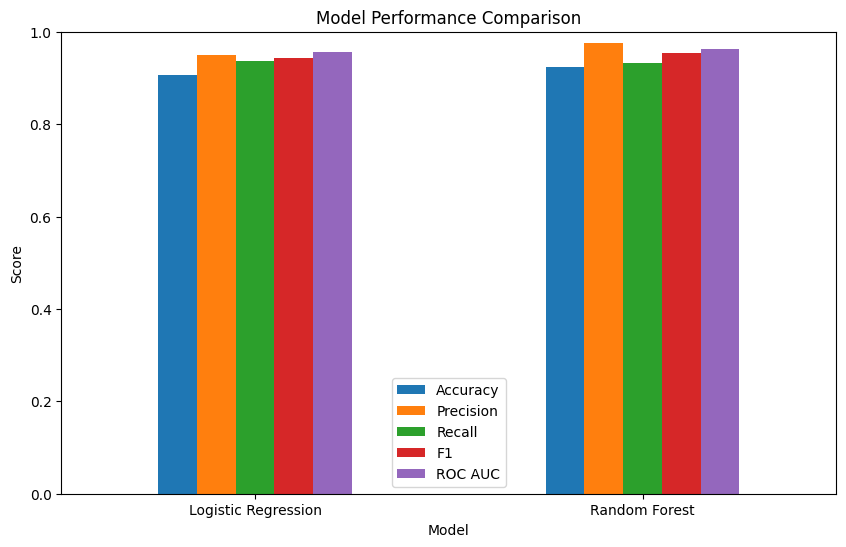

In [11]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC"])
print("\nModel Comparison:\n", results_df)

# Plot comparison
results_df.set_index("Model")[["Accuracy","Precision","Recall","F1","ROC AUC"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()



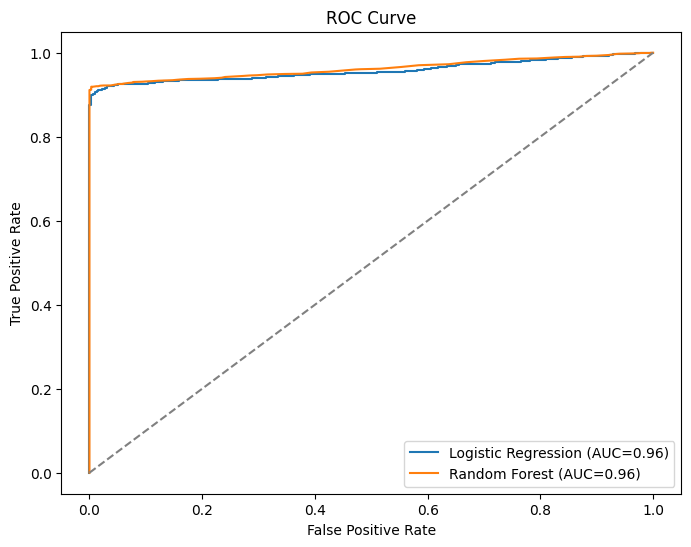

In [13]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]

    # Convert Y/N to binary (1 = Y, 0 = N)
    y_true_bin = (y_test == "Y").astype(int)

    fpr, tpr, _ = roc_curve(y_true_bin, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



Top Features:
                 Feature  Importance
4        Credit_History     0.19115
0       ApplicantIncome     0.02605
1     CoapplicantIncome     0.02275
2            LoanAmount     0.00540
5         Gender_Female     0.00235
3      Loan_Amount_Term     0.00215
6           Gender_Male     0.00190
12    Self_Employed_Yes     0.00145
11     Self_Employed_No     0.00090
15  Property_Area_Urban     0.00055


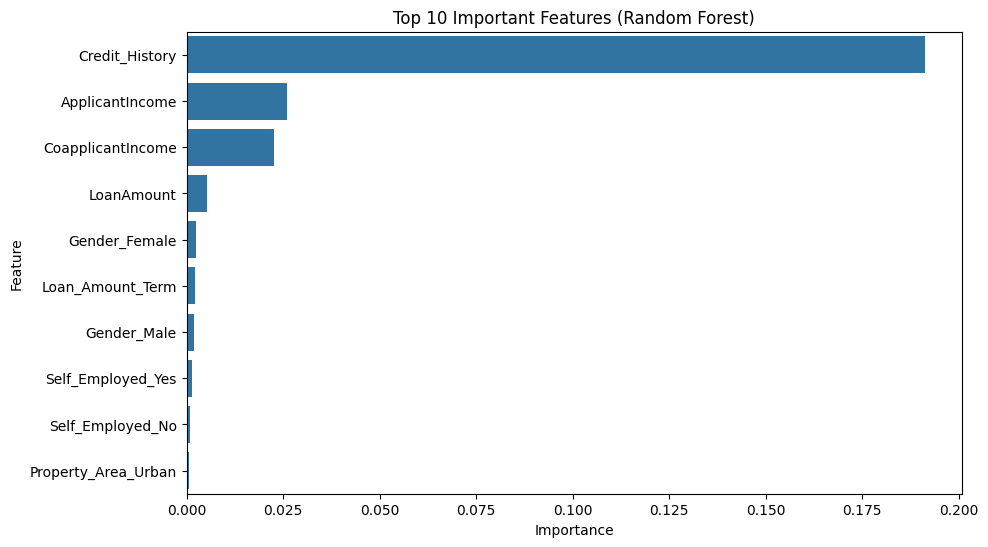

In [16]:
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', best_model)])
pipe.fit(X_train, y_train)

# Transform X_test first
X_test_transformed = pipe.named_steps['preprocessor'].transform(X_test)

# Get actual transformed feature names
num_features = numerical
cat_features = list(pipe.named_steps['preprocessor']
                        .named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical))
all_features = np.array(list(num_features) + cat_features)

# Compute permutation importance on transformed features directly
perm_importance = permutation_importance(
    pipe.named_steps['classifier'], X_test_transformed, y_test, n_repeats=10, random_state=42
)

# Build DataFrame
feature_importances = pd.DataFrame({
    "Feature": all_features[:len(perm_importance.importances_mean)],  # align lengths
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print("\nTop Features:\n", feature_importances.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


In [17]:
# Save the pipeline with best model
joblib.dump(pipe, "loan_approval_best_model.pkl")
print("✅ Best model saved as loan_approval_best_model.pkl")


✅ Best model saved as loan_approval_best_model.pkl
